# Predicting Song Popularity (Spotify)

## Resources

* resources here

## Using Spotify API to collect data

In [3]:
#import required libraries
import spotipy
import spotipy.util as util
from spotipy.oauth2 import SpotifyClientCredentials
import pandas as pd
import time
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score
from sklearn.model_selection import GridSearchCV
from xgboost import plot_importance
from scipy.stats import skew, norm, boxcox_normmax
from scipy.special import boxcox1p

In [2]:
#connecting to client
client_id = '529eee33741c45de9d12777f9b4d8f2d'
client_secret = '0c9d6e87495e45d69e3afd78356d0c23'

creds = SpotifyClientCredentials(client_id, client_secret)
sp = spotipy.Spotify(client_credentials_manager=creds)

In [3]:
#function to grab playlist from user
def getTrackIDs(user, playlist_id):
    ids = []
    playlist = sp.user_playlist(user, playlist_id)
    for item in playlist['tracks']['items']:
        track = item['track']
        ids.append(track['id'])
    return ids

#in this case we get the top 50 songs on Spotify in the U.S. 
ids = getTrackIDs('United States Top 50', '37i9dQZEVXbLRQDuF5jeBp')

In [4]:
#grab data from track
def getTrackFeatures(id):
    meta = sp.track(id)
    features = sp.audio_features(id)

    #main track items
    name = meta['name']
    album = meta['album']['name']
    artist = meta['album']['artists'][0]['name']
    release_date = meta['album']['release_date']
    length = meta['duration_ms']
    popularity = meta['popularity']

    #track features
    acousticness = features[0]['acousticness']
    danceability = features[0]['danceability']
    instrumentalness = features[0]['instrumentalness']
    loudness = features[0]['loudness']
    tempo = features[0]['tempo']
    speechiness = features[0]['speechiness']
    valence = features[0]['valence']
    time_signature = features[0]['time_signature']
    energy = features[0]['energy']
    liveness = features[0]['liveness']


    track = [name, 
             album, 
             artist, 
             release_date, 
             length, 
             popularity, 
             acousticness, 
             danceability, 
             instrumentalness, 
             loudness, 
             tempo, 
             speechiness, 
             valence, 
             time_signature, 
             energy, 
             liveness]
    
    return track

In [5]:
#grab tracks
tracks = []

for i in range(len(ids)):
    time.sleep(.5)
    track = getTrackFeatures(ids[i])
    tracks.append(track)

In [6]:
#dataframe for top 50 songs
current50 = pd.DataFrame(tracks,
                 columns = ['name',
                            'album',
                            'artist',
                            'release_date',
                            'length',
                            'popularity',
                            'acousticness',
                            'danceability',
                            'instrumentalness',
                            'loudness',
                            'tempo',
                            'speechiness',
                            'valence',
                            'time_signature',
                           'energy',
                           'liveness'])

### Gather Data on past top songs (2010 - 2019)

In [7]:
#read data from csv
stored_songs = pd.read_csv(r'D:\Data Science\Spotify API\data\stored_songs.csv')
stored_songs.drop('Unnamed: 0', axis = 1, inplace=True)

In [8]:
#add new songs to top 50 dataframe
stored_songs = pd.concat([stored_songs, current50], ignore_index=True, sort=True)

In [9]:
stored_songs.drop_duplicates(inplace=True)
stored_songs['genre'] = None

In [10]:
#reformat order of dataframe
order =                     ['name',
                            'artist',
                             'album',
                             'genre',
                            'release_date',
                             'length',
                            'acousticness',
                            'danceability',
                            'instrumentalness',
                            'loudness',
                             'liveness',
                            'tempo',
                             'energy',
                            'speechiness',
                            'valence',
                            'time_signature',
                            'popularity']
stored_songs = pd.DataFrame(stored_songs, columns = order)

In [11]:
#turn 2010 - 2019 song csv into dataframe
songs10_19 = pd.read_csv(r"D:\Data Science\Spotify API\data\songs10_19songs.csv", encoding='ISO-8859-1')
songs10_19.drop('Unnamed: 0',axis = 1, inplace=True)
songs10_19['album'] = None
songs10_19['instrumentalness'] = None
songs10_19['time_signature'] = None

In [12]:
songs10_19 = pd.DataFrame(songs10_19, columns = order)

In [13]:
#rename columns
columns = ['name',
            'artist',
           'genre',
            'release_date',
            'tempo',
            'energy',
            'danceability',
            'loudness',
            'liveness',
            'valence',
            'length',
            'acoustiness',
            'speechiness',
            'popularity',
            'album',
            'instrumentalness',
            'time_signature']
songs10_19.columns = [i for i in columns]

## Extracting Missing Data From Spotify API

In [14]:
#get missing data
def artist_info(lookup) :

    try :
        artist = sp.search(lookup)
        artist_uri = artist['tracks']['items'][0]['album']['artists'][0]['uri']
        track_uri = artist['tracks']['items'][0]['uri']

        release_date = artist['tracks']['items'][0]['album']['release_date']
        album = artist['tracks']['items'][0]['album']

        artist = sp.artist(artist_uri)
        popularity = artist['popularity']

        audio_features = sp.audio_features(track_uri)[0]

        acousticness = audio_features['acousticness']
        instrumentalness = audio_features['instrumentalness']
        time_signature = audio_features['time_signature']

        return popularity, acousticness, instrumentalness, time_signature, album

    except :
        return [None]*5

In [15]:
#create lookup for accuracy
songs10_19['lookup'] = songs10_19['name'] + '' + songs10_19['artist']

In [16]:
#apply function
songs10_19['popularity_2'], songs10_19['acousticness'], songs10_19['instrumentalness'], songs10_19['time_signature'], songs10_19['album'] = zip(*songs10_19['lookup'].map(artist_info))

In [17]:
#merge df
top_songs = pd.concat([stored_songs, songs10_19], ignore_index = True, sort = True)

In [18]:
#clean df
songs10_19.drop('lookup', axis = 1, inplace=True)

## What Makes A Song Popular?

### Investigation and Visualization

* Austin's Part

## Investigating Machine Learning Models to Predict Song Popularity

In [4]:
#collect data
data = pd.read_csv(r"D:\Data Science\Spotify API\data\data.csv")

In [5]:
#investigate data
data.head(5)

,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo,valence,year
0,0.995,['Carl Woitschach'],0.708,158648,0.1950,0,6KbQ3uYMLKb5jDxLF7wYDD,0.563,10,0.1510,-12.428,1,Singende Bataillone 1. Teil,0,1928,0.0506,118.469,0.7790,1928
1,0.994,"['Robert Schumann', 'Vladimir Horowitz']",0.379,282133,0.0135,0,6KuQTIu1KoTTkLXKrwlLPV,0.901,8,0.0763,-28.454,1,"Fantasiestücke, Op. 111: Più tosto lento",0,1928,0.0462,83.972,0.0767,1928
2,0.604,['Seweryn Goszczyński'],0.749,104300,0.2200,0,6L63VW0PibdM1HDSBoqnoM,0.000,5,0.1190,-19.924,0,Chapter 1.18 - Zamek kaniowski,0,1928,0.9290,107.177,0.8800,1928
3,0.995,['Francisco Canaro'],0.781,180760,0.1300,0,6M94FkXd15sOAOQYRnWPN8,0.887,1,0.1110,-14.734,0,Bebamos Juntos - Instrumental (Remasterizado),0,1928-09-25,0.0926,108.003,0.7200,1928
4,0.990,"['Frédéric Chopin', 'Vladimir Horowitz']",0.210,687733,0.2040,0,6N6tiFZ9vLTSOIxkj8qKrd,0.908,11,0.0980,-16.829,1,"Polonaise-Fantaisie in A-Flat Major, Op. 61",1,1928,0.0424,62.149,0.0693,1928


In [6]:
data.drop(['key', 'id', 'mode'], axis = 1, inplace=True)

In [7]:
data.dtypes

acousticness        float64
artists              object
danceability        float64
duration_ms           int64
energy              float64
explicit              int64
instrumentalness    float64
liveness            float64
loudness            float64
name                 object
popularity            int64
release_date         object
speechiness         float64
tempo               float64
valence             float64
year                  int64
dtype: object

In [8]:
data.describe()

,acousticness,danceability,duration_ms,energy,explicit,instrumentalness,liveness,loudness,popularity,speechiness,tempo,valence,year
count,169909.000000,169909.000000,1.699090e+05,169909.000000,169909.000000,169909.000000,169909.000000,169909.000000,169909.000000,169909.000000,169909.000000,169909.000000,169909.000000
mean,0.493214,0.538150,2.314062e+05,0.488593,0.084863,0.161937,0.206690,-11.370289,31.556610,0.094058,116.948017,0.532095,1977.223231
std,0.376627,0.175346,1.213219e+05,0.267390,0.278679,0.309329,0.176796,5.666765,21.582614,0.149937,30.726937,0.262408,25.593168
min,0.000000,0.000000,5.108000e+03,0.000000,0.000000,0.000000,0.000000,-60.000000,0.000000,0.000000,0.000000,0.000000,1921.000000
25%,0.094500,0.417000,1.710400e+05,0.263000,0.000000,0.000000,0.098400,-14.470000,12.000000,0.034900,93.516000,0.322000,1957.000000
50%,0.492000,0.548000,2.086000e+05,0.481000,0.000000,0.000204,0.135000,-10.474000,33.000000,0.045000,114.778000,0.544000,1978.000000
75%,0.888000,0.667000,2.629600e+05,0.710000,0.000000,0.086800,0.263000,-7.118000,48.000000,0.075400,135.712000,0.749000,1999.000000
max,0.996000,0.988000,5.403500e+06,1.000000,1.000000,1.000000,1.000000,3.855000,100.000000,0.969000,244.091000,1.000000,2020.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002364842CD88>,
      dtype=object)

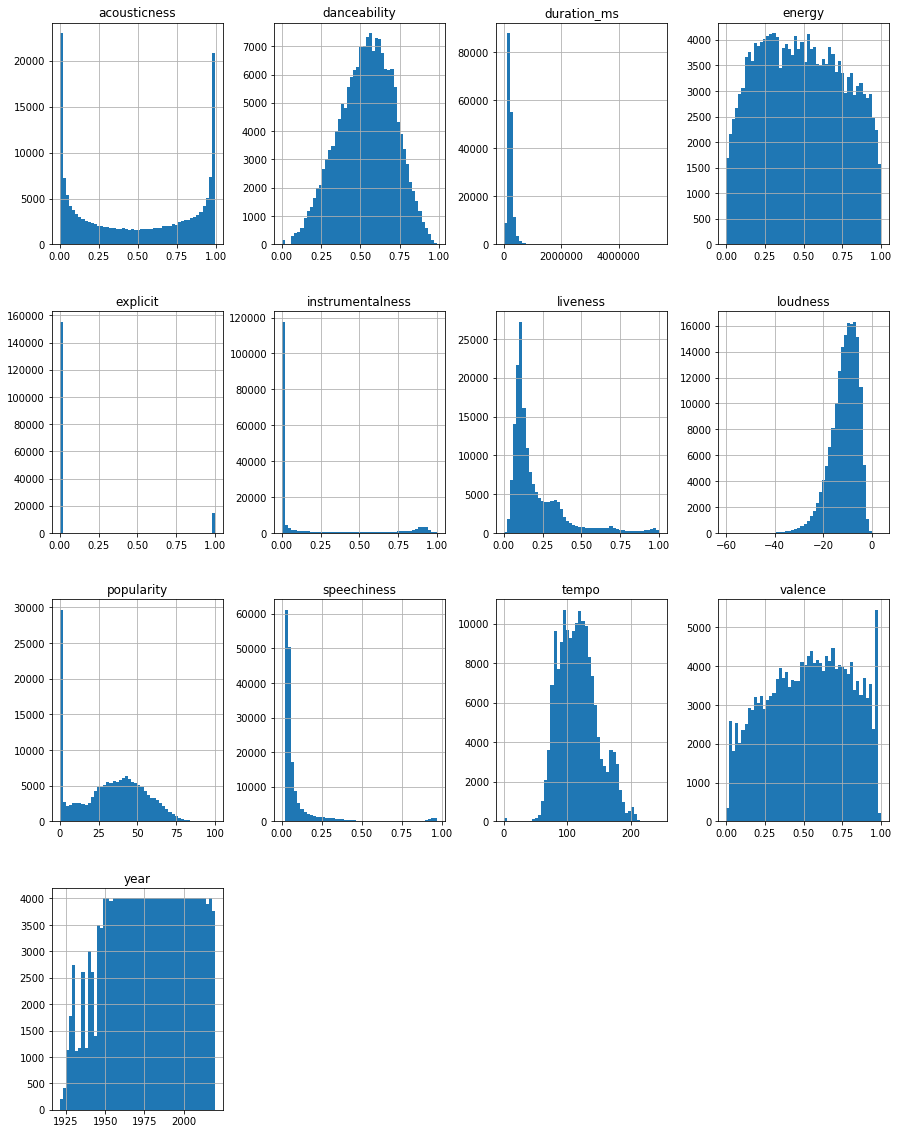

In [9]:
data.hist(bins = 50, figsize = (15,20))

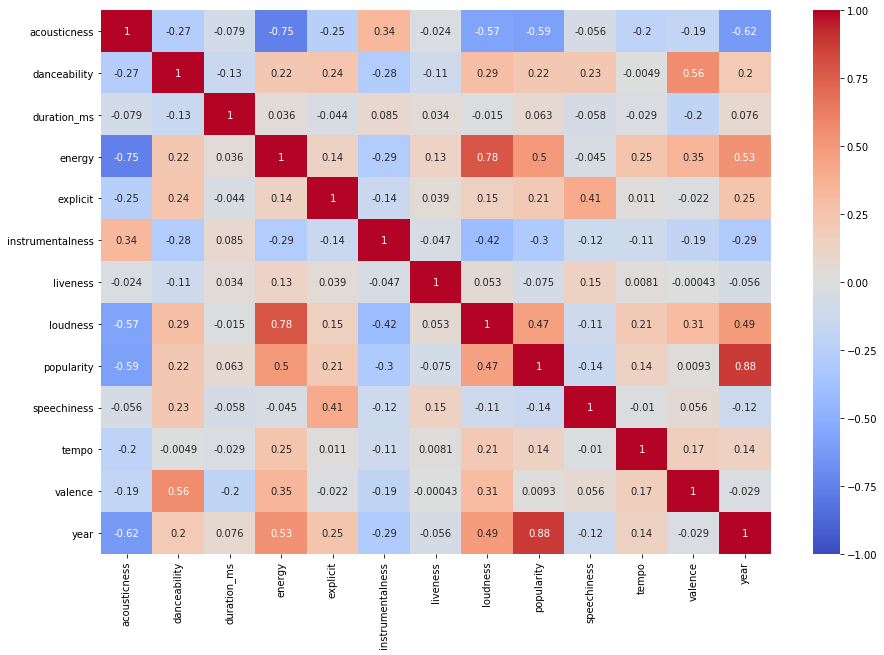

In [10]:
#investigate correlations
corr_matrix = data.corr()
fig, ax = plt.subplots(figsize = (15,10))
sns.heatmap(corr_matrix, annot = True, fmt='.2g', vmin = -1, vmax = 1, center = 0, cmap = 'coolwarm')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002364EDA6BC8>,
      dtype=object)

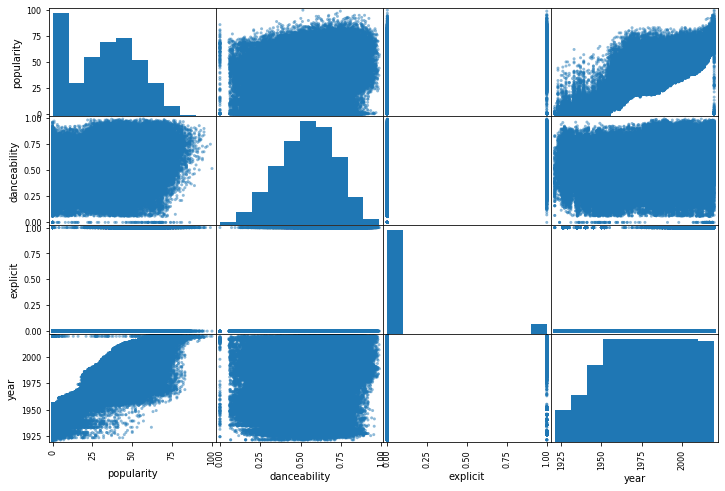

In [11]:
#plot correlated numerical attributes with popularity
cols = ['popularity', 'danceability', 'explicit', 'year']
scatter_matrix(data[cols], figsize = (12,8))

In [12]:
data.isna().sum()

acousticness        0
artists             0
danceability        0
duration_ms         0
energy              0
explicit            0
instrumentalness    0
liveness            0
loudness            0
name                0
popularity          0
release_date        0
speechiness         0
tempo               0
valence             0
year                0
dtype: int64

In [13]:
years_cat = data[['year']]

#use one hot encoder 
year_cat = pd.get_dummies(data['year'], prefix = 'year')

data = pd.concat([data, year_cat], axis = 1)
data.drop('year', axis = 1, inplace = True)
numericals = data.drop(['artists', 'name', 'release_date'], axis = 1)

## Feature Engineering

In [14]:
numericals['class'] = ''

#create classes
numericals.loc[numericals['popularity'] >= 90, 'class'] = 'top hit'
numericals.loc[(numericals['popularity'] < 90) &  (numericals['popularity']>= 70), 'class'] = 'highly popular'
numericals.loc[(numericals['popularity'] < 70) &  (numericals['popularity']>= 50), 'class'] = 'popular'
numericals.loc[(numericals['popularity'] < 50) &  (numericals['popularity']>= 30), 'class'] = 'average'
numericals.loc[(numericals['popularity'] < 30) &  (numericals['popularity']>= 15), 'class'] = 'low interest'
numericals.loc[(numericals['popularity'] < 15) &  (numericals['popularity']>= 0), 'class'] = 'no interest'
numericals['class'].value_counts()

#onehot encode class column
class_cat = pd.get_dummies(numericals['class'], prefix = 'class')
numericals = pd.concat([numericals, class_cat], axis = 1)

numericals.drop('class', axis = 1, inplace = True)

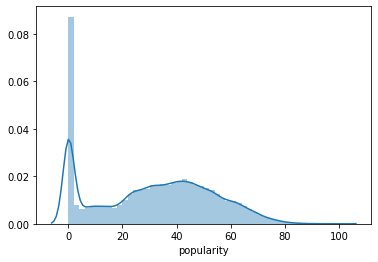

In [15]:
sns.distplot(data['popularity'])

In [16]:
data = data[data['popularity'] > 0]

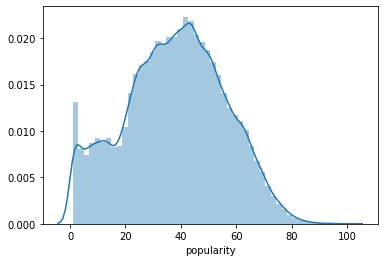

In [17]:
sns.distplot(data['popularity'])

When we remove 0 from the data we get a much more normalized plot which should help out our model. Having the data normalized is an important assumption in order to continue forward and develop a good algorithm for predicting song popularity. We see that there is a large cluster of data having 0 popularity. These clusters may create some noise in our model which would reduce accuracy.

The next step is to determine the skewness of our predictors. We should use a Box-Cox transformation where necessary to create more normalized values. 

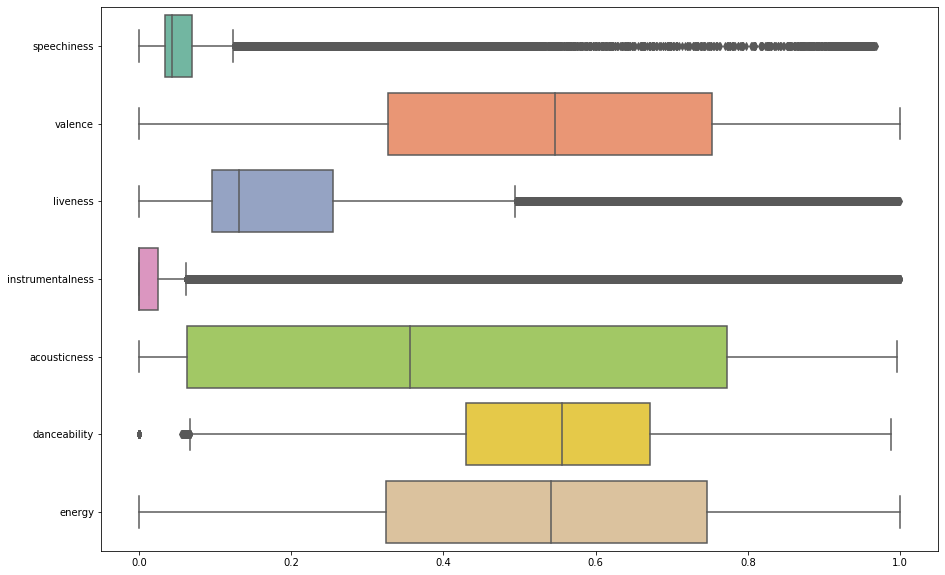

In [18]:
#values on a 0-1 scale: speechiness, valence, liveness, instrumentalness, acousticness, danceability, energy
cols = ['speechiness', 'valence', 'liveness', 'instrumentalness', 'acousticness', 'danceability', 'energy']
fig, ax = plt.subplots(figsize = (15,10))
sns.boxplot(data = data[cols], orient = 'h', palette = 'Set2')

In [19]:
skew_features = data[cols].apply(lambda x: skew(x)).sort_values(ascending = False)
skew_features.head(7)

speechiness         4.731045
liveness            2.221217
instrumentalness    2.084142
acousticness        0.263367
valence            -0.113464
energy             -0.126643
danceability       -0.227652
dtype: float64

Using a Box-Cox transformation on any variable >.5 skew will hopefully transform our data to be more normalized.

In [20]:
high_skew = skew_features[skew_features > 0.5]
skew_df = pd.DataFrame({'Skewed': high_skew})
skew_index = skew_df.index

In [21]:
for i in skew_index:
    data[i] = boxcox1p(data[i], boxcox_normmax(data[i] + 1))

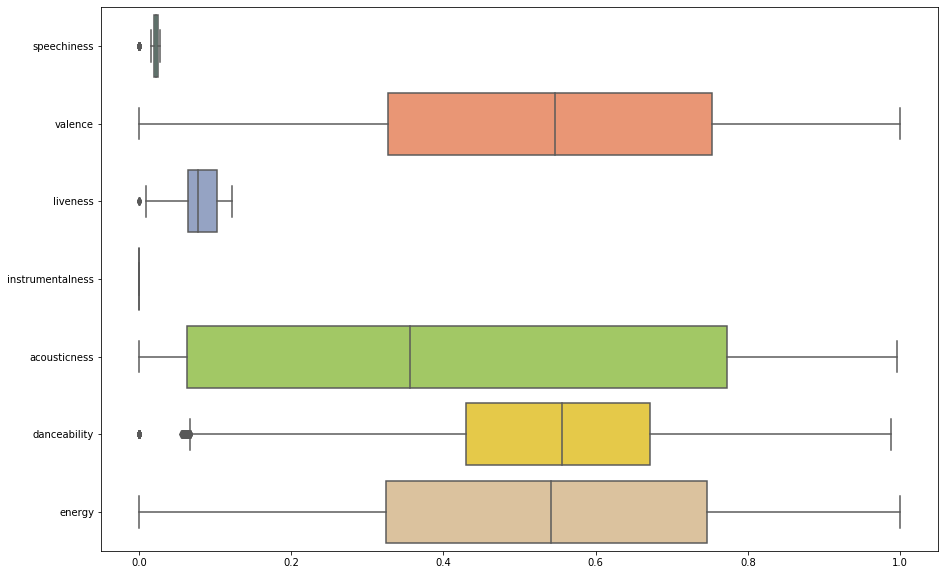

In [22]:
cols = ['speechiness', 'valence', 'liveness', 'instrumentalness', 'acousticness', 'danceability', 'energy']
fig, ax = plt.subplots(figsize = (15,10))
sns.boxplot(data = data[cols], orient = 'h', palette = 'Set2')

In [23]:
data[cols].skew()

speechiness         0.027288
valence            -0.113466
liveness            0.041998
instrumentalness    0.022901
acousticness        0.263370
danceability       -0.227655
energy             -0.126644
dtype: float64

Features look relatively normalized now. Our skew stays between 0 - 0.27.

### Training and Testing Data

In [24]:
train_set = numericals.sample(frac = 0.8, random_state = 42)

In [25]:
X_train = train_set.drop('popularity', axis = 1)
y_train = train_set['popularity']

In [26]:
X_test = numericals.drop(train_set.index)
X_test.drop('popularity', axis = 1, inplace = True)
y_test = numericals.drop(train_set.index)['popularity']

In [27]:
#scaling data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [43]:
#y_pred.mean() / metrics.mean_squared_error(y_test, y_pred)

Our algorithm has a fairly large root mean squared error. In the figure above we see that the tail end increases very suddenly and the predictions lag to keep up. Otherwise, our model seems to follow along. We should investigate further to see if we can make further optimazations and improve the predictions of the tail end.

In [44]:
#features = pd.Series(gb.feature_importances_, index = X_train.columns)
#features.nlargest(20).plot(kind = 'barh')
#plt.show()

### Models

In [109]:
lin_reg = LinearRegression()
gb = GradientBoostingRegressor()
xgb = XGBRegressor()
ridge = Ridge(alpha = 1, solver = 'cholesky')
rfr = RandomForestRegressor()

### Model Visualization & Scores

In [112]:
def plot_df(y_pred, y_test):
    y_pred = y_pred.reshape(-1,1)
    y_pred_df = pd.DataFrame(y_pred)
    y_test_df = pd.DataFrame(y_test)
    y_pred_df.columns = ['predictions']
    y_test_df.columns = ['popularity']
    y_pred_df.sort_values('predictions', inplace = True)
    y_pred_df.reset_index(drop = True, inplace = True)
    y_test_df.sort_values('popularity', inplace = True)
    y_test_df.reset_index(drop = True, inplace = True)
    plt.plot(y_pred_df, color = colors[i], linewidth = 2, alpha = 0.8)
    plt.plot(y_test_df, linewidth = 2, color = 'red')
    plt.title('Models')
    plt.legend([j for j in legend_names], loc = 'upper left')   

In [113]:
MAE = []
MSE = []
RMSE = []
R2 = []

def append_scores(y_pred, y_test):
    MAE.append(metrics.mean_absolute_error(y_test, y_pred))
    MSE.append(metrics.mean_squared_error(y_test, y_pred))
    RMSE.append(np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
    R2.append(metrics.r2_score(y_test, y_pred))

,name,R-Squared,MAE,MSE,RMSE
0,LinearRegression,0.958173,3.483447,19.495660,4.415389
1,GradientBoostingRegressor,0.956168,3.683893,20.429841,4.519938
2,XGBRegressor,0.962637,3.247296,17.414903,4.173117
3,Ridge,0.958171,3.484464,19.496177,4.415447
4,RandomForestRegressor,0.962760,3.184450,17.357458,4.166228


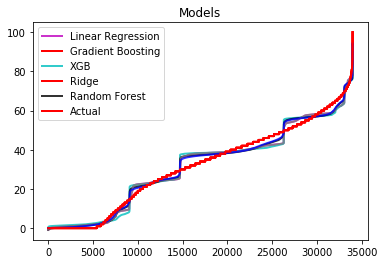

In [114]:
models = [lin_reg, gb, xgb, ridge, rfr]
names = []
colors = ['m', 'c', 'black', 'grey', 'blue']
legend_names = ['Linear Regression', 'Gradient Boosting', 'XGB', 'Ridge', 'Random Forest', 'Actual']
i = 0
for model in models:
    if model != xgb:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        append_scores(y_pred, y_test)
        names.append(type(model).__name__)
        plot_df(y_pred, y_test)
                    
    else:
        model.fit(X_train.values, y_train)
        y_pred = model.predict(X_test.values)
        append_scores(y_pred, y_test)
        names.append(type(model).__name__)
        plot_df(y_pred, y_test)
        
    i+=1


            
scores = pd.DataFrame({'name': names,
                       'R-Squared': R2,
                      'MAE': MAE,
                      'MSE': MSE,
                      'RMSE': RMSE}) 

scores.head(10)

Our best model from above is the Random Forest Regressor with XGBoost close behind. We will take these models and fine tune the hyperparameters to try and reduce model error down even more. 

#### Hyperparameter tuning for stacking & blending

In [92]:
#random forest param grid
param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': ['6' ,'8' ,'9'],
}

In [108]:
rfr = RandomForestRegressor(n_estimators = 500, max_depth = 30, max_features = 'auto', random_state = 42, n_jobs=-1)
rfr.fit(X_train, y_train)
y_pred = rfr.predict(X_test)
print_scores(y_test, y_pred)

MAE: 3.170140961694129
MSE: 17.042605170198673
Square MSE: 4.128269028321516
R-Squared: 0.963435498189042


In [63]:
#xgb param grid
param_grid = {
    'n_estimators': [100, 200, 500, 1000],
    'learning_rate': [0.01, 0.1, 0.3],
    'max_depth': ['9','12', '15'],
    'gamma': [0, 0.1, 0.5]    
}

In [64]:
#grid_search = GridSearchCV(estimator = xgb, param_grid = param_grid, cv = 5, n_jobs=-1)
#grid_search.fit(X_train, y_train)
#grid_search.best_estimator_

In [47]:
def print_scores(y_test, y_pred):
    print('MAE: ' + str(metrics.mean_absolute_error(y_test, y_pred)))
    print('MSE: ' + str(metrics.mean_squared_error(y_test, y_pred)))
    print('RMSE: ' + str(np.sqrt(metrics.mean_squared_error(y_test, y_pred))))
    print('R-Squared: ' + str(metrics.r2_score(y_test, y_pred)))

In [54]:
xgb_best = XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth='9',
             min_child_weight=1, monotone_constraints='()',
             n_estimators=224, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=42, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

xgb_best.fit(X_train, y_train)
y_pred = xgb_best.predict(X_test)
print_scores(y_test, y_pred)

MAE: 3.20570564816831
MSE: 17.203956374617373
RMSE: 4.147765226554822
R-Squared: 0.9630893230387496


In [53]:
ridge_reg = Ridge(alpha = 1, solver = 'cholesky', random_state = 42)
ridge_reg.fit(X_train, y_train)
y_pred = ridge_reg.predict(X_test)
print_scores(y_test, y_pred)

MAE: 3.4844638484757593
MSE: 19.49617658757342
RMSE: 4.415447495732841
R-Squared: 0.958171419391348


### Stacking Model

In [28]:
xgb = XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth='9',
             min_child_weight=1, monotone_constraints='()',
             n_estimators=224, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=42, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

lin_reg = LinearRegression()

gb = GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=6,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=500,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=42, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

ridge = Ridge(alpha = 1, solver = 'cholesky', random_state = 42)

rfr = RandomForestRegressor(n_estimators = 500, max_depth = 30, max_features = 'auto', random_state = 42, n_jobs=-1)

In [29]:
from mlxtend.regressor import StackingCVRegressor
stack_gen = StackingCVRegressor(regressors = (xgb, gb, lin_reg, ridge, rfr),
                               meta_regressor = rfr,
                               use_features_in_secondary = True)

In [30]:
stack_gen.fit(X_train.values, y_train)

StackingCVRegressor(cv=5,
                    meta_regressor=RandomForestRegressor(bootstrap=True,
                                                         ccp_alpha=0.0,
                                                         criterion='mse',
                                                         max_depth=30,
                                                         max_features='auto',
                                                         max_leaf_nodes=None,
                                                         max_samples=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                             

In [51]:
y_pred = stack_gen.predict(X_test.values)

In [52]:
print_scores(y_test, y_pred)

MAE: 3.1476849461788223
MSE: 16.898989540385454
RMSE: 4.110838058156202
R-Squared: 0.9637436220881728


# Blended Model

By blending we create a more robust model that is less sensitive to outliers. 

In [33]:
xgb.fit(X_train, y_train)
rfr.fit(X_train, y_train)
lin_reg.fit(X_train, y_train)
gb.fit(X_train.values, y_train)
ridge.fit(X_train, y_train)

Ridge(alpha=1, copy_X=True, fit_intercept=True, max_iter=None, normalize=False,
      random_state=42, solver='cholesky', tol=0.001)

In [48]:
def blend(X_test):
    return ((0.25 * xgb.predict(X_test)) + \
            0.25 * rfr.predict(X_test) + \
           0.5 * stack_gen.predict(np.array(X_test)))

print('MAE: ' + str(metrics.mean_absolute_error(y_test, blend(X_test))))
print('MSE: ' + str(metrics.mean_squared_error(y_test, blend(X_test))))
print('RMSE: ' + str(np.sqrt(metrics.mean_squared_error(y_test, blend(X_test)))))
print('R-Squared: ' + str(metrics.r2_score(y_test, blend(X_test))))

MAE: 3.152426233824607
MSE: 16.806964943764793
RMSE: 4.099629854482572
R-Squared: 0.963941058659412


### Best Model 

In [115]:
names.append('Stacked')
names.append('Blended')
#stack
MAE.append(3.1476849461788223)
MSE.append(16.898989540385454)
RMSE.append(4.110838058156202)
R2.append(0.9637436220881728)

#blend
R2.append(0.963941058659412)
MAE.append(3.152426233824607)
MSE.append(16.806964943764793)
RMSE.append(4.099629854482572)

In [197]:
scores = pd.DataFrame({'Model': names,
                       'R-Squared': R2,
                      'MAE': MAE,
                      'MSE': MSE,
                      'RMSE': RMSE})
scores.head(10)

,Model,R-Squared,MAE,MSE,RMSE
0,Linear,0.958173,3.483447,19.495660,4.415389
1,Gradient Boost,0.956168,3.683893,20.429841,4.519938
2,XGB,0.962637,3.247296,17.414903,4.173117
3,Ridge,0.958171,3.484464,19.496177,4.415447
4,Random Forest,0.962760,3.184450,17.357458,4.166228
5,Stacked,0.963744,3.147685,16.898990,4.110838
6,Blended,0.963941,3.152426,16.806965,4.099630


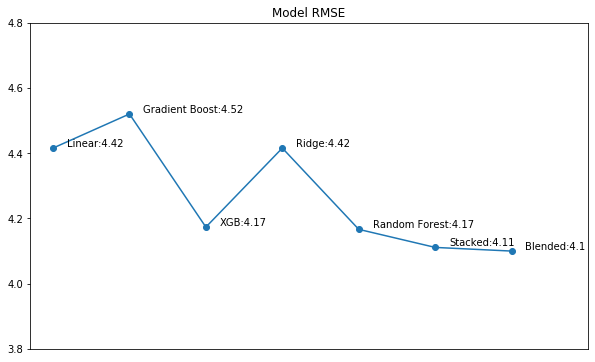

In [195]:
fig, az = plt.subplots(figsize = (10,6))
plt.plot(scores['RMSE'], '-o')
plt.xlim(-0.3, 7)
plt.ylim(3.8, 4.8)
plt.xticks([])
plt.title('Model RMSE')
names = ['Linear', 'Gradient Boost', 'XGB', 'Ridge', 'Random Forest', 'Stacked', 'Blended']
i = 0
j = 0
for rmse in scores['RMSE']:
    plt.annotate(names[j] + ':' + str(round(rmse, 2)), xy = (i + 0.18, rmse + 0.005))
    i+=1
    j+=1

Using GridSearchCV helped us identify the best parameters to use for our models. To reduce error even further both stacked and blended techniques were used. These were the most accurate and are less sensitive to outliers.